In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix,bmat
import xgboost as xgb
import itertools, gc, pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [2]:
cols = ['tourn_num','skill_estimate_percentile','not_seen','observation_count_percentile','Start_Z_Coordinate',
        'Player_First_Name','Player_Last_Name','Cat','Distance_from_hole','Green_to_work_with',
        'from_the_tee_box_mask','Strokes_from_starting_location','Course_#','Hole','loc_string',
        'loc_string_hole','windSpeed','temperature']
data = pd.concat([pd.read_csv('data/%d.csv.gz' % year,usecols=cols) for year in range(2003,2018)])

In [3]:
data.loc[data.from_the_tee_box_mask,'Cat'] = 'Tee Box'
data = data.drop('from_the_tee_box_mask',axis=1)

In [4]:
data.not_seen = data.not_seen.astype(float)
data.Strokes_from_starting_location = data.Strokes_from_starting_location.astype(float)
data.skill_estimate_percentile = data.skill_estimate_percentile.fillna(.5)
data.observation_count_percentile = data.observation_count_percentile.fillna(.5)
data.Start_Z_Coordinate = data.Start_Z_Coordinate/data.Distance_from_hole
data.loc[data.Start_Z_Coordinate.abs()>1,'Start_Z_Coordinate'] = data.loc[data.Start_Z_Coordinate.abs()>1,
                                                                          'Start_Z_Coordinate']\
                                                                          .apply(lambda x: 1 if x>0 else -1)
data.windSpeed = data.windSpeed.fillna(data.windSpeed.mean())
data.temperature = data.temperature.fillna(data.temperature.mean())

In [5]:
(data.Start_Z_Coordinate>0).mean()

0.27476835023104323

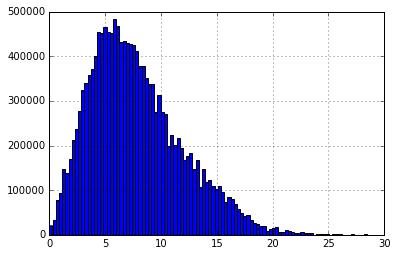

In [6]:
data.windSpeed.hist(bins=100);

In [7]:
def prepare_data(cat,num_tourns,with_distance,with_gtww,with_slope,with_skill_estimates,
                 with_course_hole,with_weather,with_locs):
    num_tournaments = len(pd.unique(data.tourn_num))
    trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
    tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
    sub = data[data.Cat==cat].reset_index(drop=True)
    trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
    tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
    cols = []
    if with_distance: cols.append('Distance_from_hole')
    if with_gtww: cols.append('Green_to_work_with')
    if with_slope: cols.append('Start_Z_Coordinate')
    if with_skill_estimates: cols.extend(['skill_estimate_percentile','not_seen',
                                          'observation_count_percentile'])
    if with_weather: cols.extend(['windSpeed','temperature'])
    X = sub[cols].values
    y = sub.Strokes_from_starting_location.values
    if with_course_hole:
        course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
        course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
                                        for tup in sub[['Course_#','Hole']].values])
    else:
        course_strings, course_hole_strings = [], []
    if with_locs:
        loc_strings = sub.loc_string.values
        loc_strings_hole = sub.loc_string_hole.values
    else:
        loc_strings, loc_strings_hole = [], []
    return X,y,course_strings,course_hole_strings,loc_strings,loc_strings_hole,trains,tests

In [8]:
def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

def run(cat,num_tourns,with_distance,with_gtww,with_slope,with_skill_estimates,
        with_course_hole,with_weather,with_locs,params,eval_pct):
    (X, y, course_strings, course_hole_strings, 
     loc_strings, loc_strings_hole, trains, tests) = prepare_data(cat,num_tourns,with_distance,with_gtww,
                                                                  with_slope,with_skill_estimates,
                                                                  with_course_hole,with_weather,with_locs)
    if with_course_hole or with_locs:
        X = csc_matrix(X)
    results = []
    for u,(train,test) in enumerate(zip(trains,tests)):
        gc.collect()
        if with_course_hole or with_locs:
            X_train, X_test = X.copy()[train], X.copy()[test]
        else:
            X_train, X_test = np.copy(X)[train], np.copy(X)[test]
        if with_course_hole:
            lb1 = LabelBinarizer(sparse_output=True)
            lb2 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb1.fit_transform(course_strings[train]),
                             lb2.fit_transform(course_hole_strings[train])]],format='csc')
            X_test = bmat([[X_test,lb1.transform(course_strings[test]),
                            lb2.transform(course_hole_strings[test])]],format='csc')
        if with_locs:
            lb1 = LabelBinarizer(sparse_output=True)
            lb2 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb1.fit_transform(loc_strings[train]),
                             lb2.fit_transform(loc_strings_hole[train])]],format='csc')
            X_test = bmat([[X_test,lb1.transform(loc_strings[test]),
                            lb2.transform(loc_strings_hole[test])]],format='csc')
        
        if u%7==0:
            num_trees = find_num_trees(X_train,y[train],params,eval_pct)
        dtrain = xgb.DMatrix(X_train,label=y[train])
        dtest = xgb.DMatrix(X_test)
        params['base_score'] = y[train].mean()
        bst = xgb.train(params,dtrain,num_trees)
        preds = bst.predict(dtest)
        error = np.mean((preds-y[test])**2)
        mean_error = np.mean((np.mean(y[train])-y[test])**2)
        r_sq = (mean_error-error)/mean_error
        #print len(test),num_trees,r_sq
        results.append(r_sq)
    mean, std_err = np.mean(results), np.std(results)/num_tourns**.5
    return (mean-std_err,mean+std_err)

In [9]:
cats = ['Other','Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker']

Just Distance

In [ ]:
depths = [3,5,7]
subsample = [.8,1]
min_weight = [1,5,15]
lamba = [5,50]
eta = [.03,.07]
eval_pct = [.05,.20]

In [ ]:
results1 = {}
for cat in cats:
    if cat not in results1:
        results1[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,False,False,False,False,False,False,params,ep)
        print cat,(de,su,mw,la,et,ep),res
        results1[cat][(de,su,mw,la,et,ep)] = res
        with open('results1.pkl','wb') as pickle_file:
            pickle.dump(results1,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results1.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~

With Everything but Skill Estimates

In [ ]:
results2 = {}
for cat in cats:
    if cat not in results2:
        results2[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,cat!='Green',True,False,True,True,True,params,ep)
        print cat,(de,su,mw,la,et,ep),res
        results2[cat][(de,su,mw,la,et,ep)] = res
        with open('results2.pkl','wb') as pickle_file:
            pickle.dump(results2,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results2.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~

With Everything

In [ ]:
results3 = {}
for cat in cats:
    if cat not in results3:
        results3[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,cat!='Green',True,True,True,True,True,params,ep)
        print cat,(de,su,mw,la,et,ep),res
        results3[cat][(de,su,mw,la,et,ep)] = res
        with open('results3.pkl','wb') as pickle_file:
            pickle.dump(results3,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results3.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~